Merged rows: 16, Year range: 2009 - 2024
   Year  youth_unemployment_rate  gdp_index  early_leavers_education  \
0  2009                      NaN        NaN                      NaN   
1  2010                      NaN        NaN                      NaN   
2  2011                      NaN        NaN                      NaN   
3  2012                      NaN        NaN                      NaN   
4  2013                      NaN        NaN                      NaN   

   employment_rate_graduates  poverty_risk_change  inflation_rate  \
0                        NaN                  NaN             NaN   
1                        NaN                  NaN             NaN   
2                        NaN               3467.0             NaN   
3                        NaN               6383.0             NaN   
4                       74.3               5461.0             1.3   

   total_employment  total_unemployment  
0               NaN                 9.3  
1               NaN        

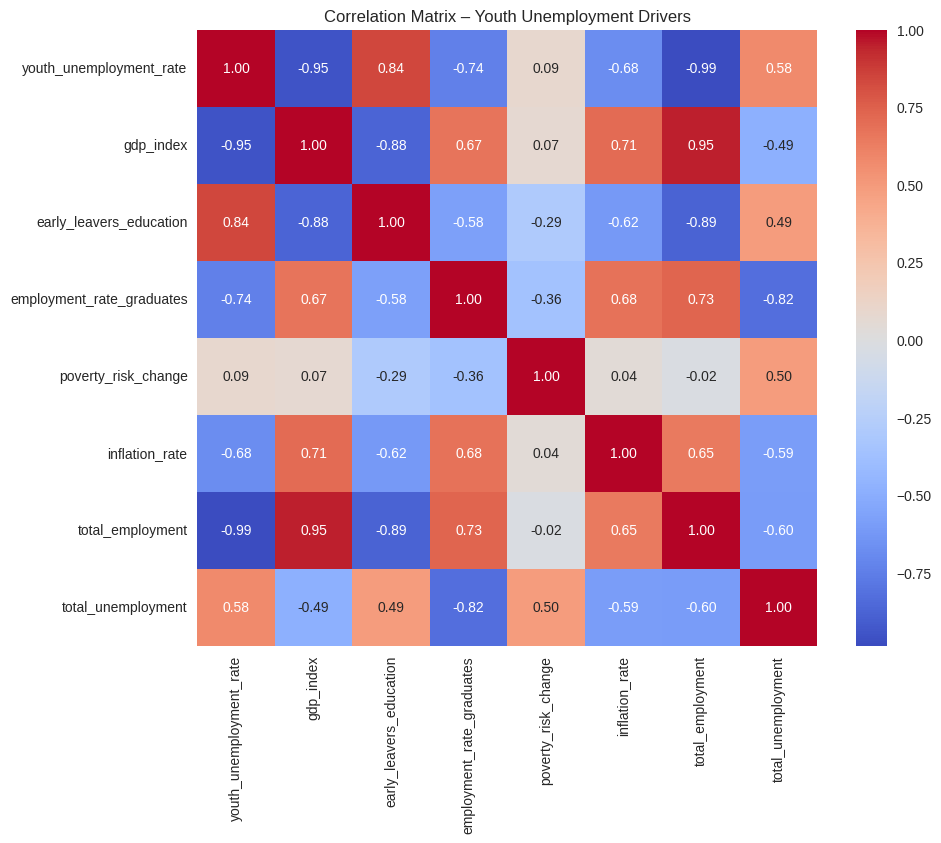

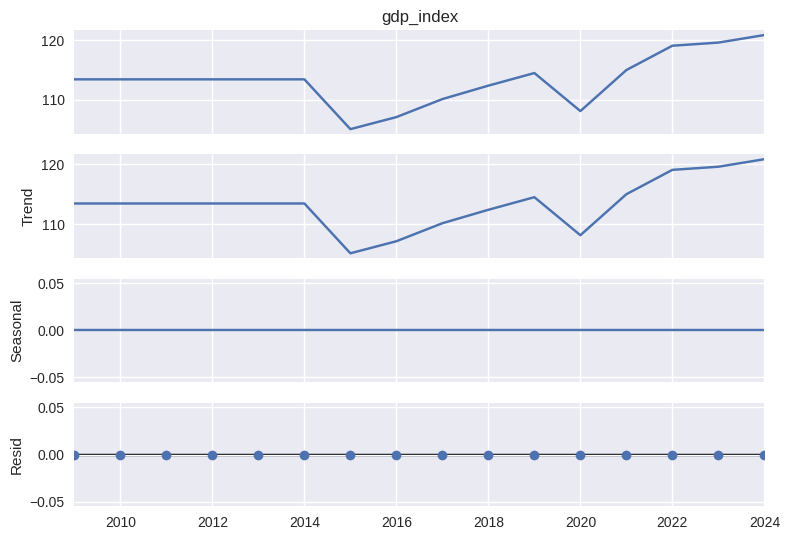

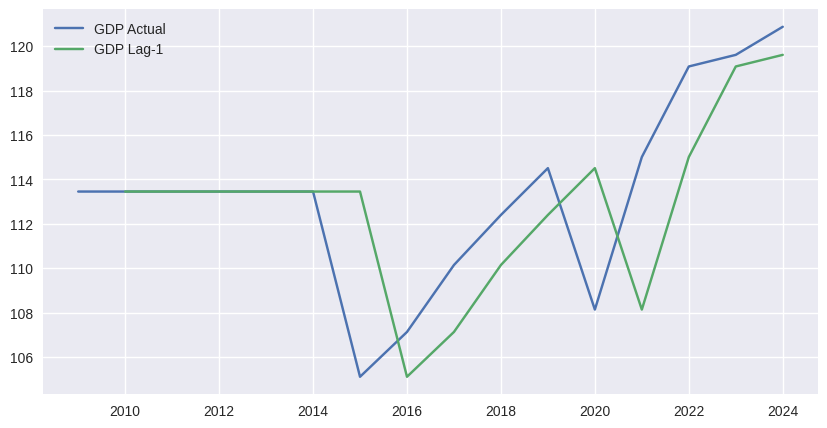

=== FULL OLS MODEL ===
                               OLS Regression Results                              
Dep. Variable:     youth_unemployment_rate   R-squared:                       0.997
Model:                                 OLS   Adj. R-squared:                  0.994
Method:                      Least Squares   F-statistic:                     328.8
Date:                     Sun, 07 Dec 2025   Prob (F-statistic):           3.35e-09
Time:                             12:57:54   Log-Likelihood:                 26.877
No. Observations:                       16   AIC:                            -37.75
Df Residuals:                            8   BIC:                            -31.57
Df Model:                                7                                         
Covariance Type:                 nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

In [37]:
# =====================================================================
# Youth Unemployment Analysis in EU – Econometric & ML
# Author: [Your Name]
# Date: December 2025
# =====================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

# =====================================================================
# 1. LOAD DATASETS
# =====================================================================
def clean_excel(file_path, sheet, skip_rows, nrows):
    df = pd.read_excel(file_path, sheet_name=sheet, skiprows=skip_rows, nrows=nrows)
    drop_cols = [c for c in df.columns if str(c).startswith("...") or str(c).startswith("Unnamed")]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    first_col = df.columns[0]
    df = df.rename(columns={first_col: "COUNTRY"})
    df["COUNTRY"] = df["COUNTRY"].astype(str).str.strip()
    df = df[df["COUNTRY"].str.upper() != "GEO (LABELS)"]
    return df

early_leavers = clean_excel("edat_lfse_04.xlsx", sheet=1, skip_rows=10, nrows=2)
poverty_data = clean_excel("ilc_peps01.xlsx", sheet=1, skip_rows=9, nrows=2)
employment_data = clean_excel("lfsa_egan2.xlsx", sheet=1, skip_rows=10, nrows=2)
graduates_employment = clean_excel("tps00053.xlsx", sheet=1, skip_rows=11, nrows=2)
inflation_data = clean_excel("tec00118.xlsx", sheet=1, skip_rows=8, nrows=2)
gdp_data = clean_excel("nama_10_gdp.xlsx", sheet=1, skip_rows=8, nrows=2)
total_unemployment_data = clean_excel("tipsun20.xlsx", sheet=1, skip_rows=9, nrows=2)
youth_unemployment_data = clean_excel("edat_lfse_22.xlsx", sheet=1, skip_rows=11, nrows=2)

# =====================================================================
# 2. CONVERT TO LONG FORMAT
# =====================================================================
def to_long(df, value_name):
    long_df = df.melt(id_vars="COUNTRY", var_name="Year", value_name=value_name)
    long_df["Year"] = pd.to_numeric(long_df["Year"], errors="coerce")
    long_df = long_df.dropna(subset=["Year"])
    long_df["Year"] = long_df["Year"].astype(int)
    return long_df[["Year", value_name]]

youth_unemployment = to_long(youth_unemployment_data, "youth_unemployment_rate")
gdp_index = to_long(gdp_data, "gdp_index")
early_leavers_rate = to_long(early_leavers, "early_leavers_education")
graduates_employment_rate = to_long(graduates_employment, "employment_rate_graduates")
poverty_change = to_long(poverty_data, "poverty_risk_change")
inflation_rate = to_long(inflation_data, "inflation_rate")
total_employment = to_long(employment_data, "total_employment")
total_unemployment = to_long(total_unemployment_data, "total_unemployment")

# =====================================================================
# 3. MERGE DATASETS
# =====================================================================
merged_data = youth_unemployment.merge(gdp_index, on="Year", how="outer") \
    .merge(early_leavers_rate, on="Year", how="outer") \
    .merge(graduates_employment_rate, on="Year", how="outer") \
    .merge(poverty_change, on="Year", how="outer") \
    .merge(inflation_rate, on="Year", how="outer") \
    .merge(total_employment, on="Year", how="outer") \
    .merge(total_unemployment, on="Year", how="outer") \
    .sort_values("Year").reset_index(drop=True)

print(f"Merged rows: {len(merged_data)}, Year range: {merged_data['Year'].min()} - {merged_data['Year'].max()}")
print(merged_data.head())

# Convert columns to numeric and fill missing values
numeric_cols = ["youth_unemployment_rate", "gdp_index", "early_leavers_education",
                "employment_rate_graduates", "poverty_risk_change",
                "inflation_rate", "total_employment", "total_unemployment"]

for col in numeric_cols:
    merged_data[col] = pd.to_numeric(merged_data[col], errors="coerce")
    merged_data[col] = merged_data[col].fillna(merged_data[col].median())

# =====================================================================
# 4. EXPLORATORY DATA ANALYSIS
# =====================================================================
print(merged_data.describe().T)

plt.figure(figsize=(10,8))
sns.heatmap(merged_data.drop("Year", axis=1).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix – Youth Unemployment Drivers")
plt.show()

# =====================================================================
# 5. TIME SERIES EXAMPLE (GDP)
# =====================================================================
gdp_series = merged_data.set_index("Year")["gdp_index"]
decomposition = seasonal_decompose(gdp_series, model="additive", period=1)
decomposition.plot()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(merged_data["Year"], merged_data["gdp_index"], label="GDP Actual")
plt.plot(merged_data["Year"], merged_data["gdp_index"].shift(1), label="GDP Lag-1")
plt.legend()
plt.show()

# =====================================================================
# 6. OLS REGRESSION
# =====================================================================
y = merged_data["youth_unemployment_rate"]
X = merged_data[["gdp_index", "early_leavers_education", "employment_rate_graduates",
                 "poverty_risk_change", "inflation_rate", "total_employment", "total_unemployment"]]

linear_model = LinearRegression()
feature_selector = SequentialFeatureSelector(linear_model, k_features="best", forward=False, floating=False, scoring="r2", cv=0)
feature_selector = feature_selector.fit(X.values, y.values)
selected_features = list(X.columns[list(feature_selector.k_feature_idx_)])

X_selected = sm.add_constant(X[selected_features])
ols_model = sm.OLS(y, X_selected).fit()
print("=== FULL OLS MODEL ===")
print(ols_model.summary())

# =====================================================================
# 6b. PARSIMONIOUS OLS MODEL (USING ONLY SIGNIFICANT VARIABLES)
# =====================================================================
X_parsimonious = merged_data[["poverty_risk_change", "inflation_rate", "total_employment", "total_unemployment"]]
X_parsimonious = sm.add_constant(X_parsimonious)
parsimonious_ols_model = sm.OLS(y, X_parsimonious).fit()
print("=== PARSIMONIOUS OLS MODEL ===")
print(parsimonious_ols_model.summary())

# =====================================================================
# 7. MACHINE LEARNING MODELS
# =====================================================================
X_ml = X_parsimonious.drop("const", axis=1)  # use only significant features
y_ml = y

X_train, X_test, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2, random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decision Tree
tree_model = DecisionTreeRegressor(random_state=123)
tree_model.fit(X_train, y_train)
tree_pred = tree_model.predict(X_test)

# Random Forest
forest_model = RandomForestRegressor(n_estimators=500, random_state=123)
forest_model.fit(X_train, y_train)
forest_pred = forest_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=123, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Support Vector Regression
svr_model = SVR(kernel="rbf", C=10, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
svr_pred = svr_model.predict(X_test_scaled)

# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

results_table = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "XGBoost", "SVM", "KNN"],
    "RMSE": [np.sqrt(mean_squared_error(y_test, tree_pred)),
             np.sqrt(mean_squared_error(y_test, forest_pred)),
             np.sqrt(mean_squared_error(y_test, xgb_pred)),
             np.sqrt(mean_squared_error(y_test, svr_pred)),
             np.sqrt(mean_squared_error(y_test, knn_pred))],
    "MAE": [mean_absolute_error(y_test, tree_pred),
            mean_absolute_error(y_test, forest_pred),
            mean_absolute_error(y_test, xgb_pred),
            mean_absolute_error(y_test, svr_pred),
            mean_absolute_error(y_test, knn_pred)],
    "R2": [r2_score(y_test, tree_pred),
           r2_score(y_test, forest_pred),
           r2_score(y_test, xgb_pred),
           r2_score(y_test, svr_pred),
           r2_score(y_test, knn_pred)]
}).round(4)

print(results_table)

# =====================================================================
# 8. HYPERPARAMETER TUNING
# =====================================================================
rf_grid = GridSearchCV(RandomForestRegressor(random_state=123),
                       {"n_estimators":[300,500], "max_depth":[None,10]},
                       cv=5, scoring="neg_root_mean_squared_error")
rf_grid.fit(X_train, y_train)
print("Optimized Random Forest:", rf_grid.best_params_, "RMSE:", -rf_grid.best_score_)

xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=123, verbosity=0),
                        {"n_estimators":[100,200], "max_depth":[3,4,5]},
                        cv=5, scoring="neg_root_mean_squared_error")
xgb_grid.fit(X_train, y_train)
print("Optimized XGBoost:", xgb_grid.best_params_, "RMSE:", -xgb_grid.best_score_)

print("Analysis Complete.")
